In [72]:
import json
import numpy as np
import pandas as pd
import cv2
import albumentations as A
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2
import random
import os

In [73]:
base_dir = "/opt/ml/segmentation/semantic-segmentation-level2-cv-11/"
data_dir = f"{base_dir}input/data/"

In [587]:
def show_img(aug_img, aug_mask):
    
    fig, axes = plt.subplots(1, 2, figsize=(7, 12))
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].set_title('aug_img')
    axes[1].set_title('aug_mask')
    axes[0].imshow(aug_img)
    axes[1].imshow(aug_mask)
    
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

category_names = ['Backgroud', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']

def save_img(the_dir, img, ann, count, cat_name):
    
#     area = ann['area']
#     if area >= 512*512/4:
#         plt.imsave(the_dir+f'/large/{cat_name}{count+i}.jpg', img)
#     elif area >= 512*512/16:
#         plt.imsave(the_dir+f'/middle/{cat_name}{count+i}.jpg', img)
#     elif area >= 512*512/64:
#         plt.imsave(the_dir+f'/small/{cat_name}{count+i}.jpg', img)
#     else:
        plt.imsave(the_dir+f'{cat_name}{count+i}.jpg', img)
        
def make_dir(category):
    
    base = '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/add_imgs'
    base_cat = f'{base}/{category}'
    os.mkdir(f'{base_cat}')
    os.mkdir(f'{base_cat}/large')
    os.mkdir(f'{base_cat}/middle')
    os.mkdir(f'{base_cat}/small')
    os.mkdir(f'{base_cat}/tiny')
    
    return base_cat

def distorted_img(idx, json, transform=None):
    img, mask, ann, image_infos = get_img(idx, json)
    
    if transform == None:
        off_img = cv2.bitwise_and(img, img, mask=mask)
        return off_img, mask, ann
    
    else:
        transform1 = A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, interpolation=1, border_mode=4, value=None, mask_value=None, shift_limit_x=None, shift_limit_y=None, always_apply=False, p=0.7)
        transformed = transform1(image=img, mask=mask)
        transform2 = A.GridDistortion(num_steps=4, distort_limit=0.2, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
        transformed = transform2(image=transformed['image'], mask=transformed['mask'])
        transform3 = A.RGBShift(r_shift_limit=0.07, g_shift_limit=0.07, b_shift_limit=0.07, always_apply=False, p=0.7)
        transformed = transform3(image=transformed['image'], mask=transformed['mask'])
    
        aug_img = transformed['image']
        aug_mask = transformed['mask']
        off_img = cv2.bitwise_and(aug_img, aug_img, mask=aug_mask)
    
        return off_img, aug_mask, ann

In [75]:
from pycocotools.coco import COCO

def get_img(idx, json):
    coco = COCO(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/{json}')
    image_id = coco.getImgIds(imgIds=idx)
    image_infos = coco.loadImgs(image_id)[0]
    images = cv2.imread(data_dir+image_infos['file_name'])
    images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
    images /= 255.0

    ann_ids = coco.getAnnIds(imgIds=image_infos['id'])
    anns = coco.loadAnns(ann_ids)

    # Load the categories in a variable
    cat_ids = coco.getCatIds()
    cats = coco.loadCats(cat_ids)

    # masks : size가 (height x width)인 2D
    # 각각의 pixel 값에는 "category id" 할당
    # Background = 0
    masks = np.zeros((image_infos["height"], image_infos["width"]))
    # General trash = 1, ... , Cigarette = 10
    anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
    for i in range(len(anns)):
        className = get_classname(anns[i]['category_id'], cats)
        pixel_value = category_names.index(className)
        masks[coco.annToMask(anns[i]) == 1] = pixel_value
    masks = masks.astype(np.int8)

    return images, masks, anns, image_infos

### Save Detatched Img
1. Save Default Image
2. Save Augmented Image

In [133]:
json_dir = f'{data_dir}battery.json'
with open(json_dir, "r") as json_file:
    data = json.load(json_file)

In [117]:
len_imgs = len(data['images'])
len_imgs

113

In [164]:
images = []

In [292]:
len(images)

791

In [626]:
listdir = os.listdir('/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train3/img')

idx = 0
count = 0
start = 0
flag=False
while flag==False:
  
    cat_name = ['clothing', 'battery', 'glass', 'metal', 'paper pack']
    cat_num = [10, 9, 5, 4, 3]
    img_dir = f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/add_imgs/{cat_name[idx]}'
    file_list = os.listdir(img_dir)
    length_count = len(file_list)
    
    for i in range(start, len(listdir)):

        img = cv2.imread(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train3/img/{listdir[i]}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ann_name = listdir[i].split('.')[0] + '.png'
        masks = cv2.imread(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train3/ann/{ann_name}')
        masks = cv2.cvtColor(masks, cv2.COLOR_BGR2GRAY)
        
        add_img = cv2.imread(img_dir+'/'+file_list[count])
        add_img = cv2.cvtColor(add_img, cv2.COLOR_BGR2RGB)
        img2gray = cv2.cvtColor(add_img, cv2.COLOR_BGR2GRAY)
        
        if idx==0 or idx==4:
            _, img2_mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
        else:
            _, img2_mask = cv2.threshold(img2gray, 5, 255, cv2.THRESH_BINARY)
        mask_inv = cv2.bitwise_not(img2_mask)

        real_mask = np.where(img2_mask==255, cat_num[idx], img2_mask) #category 

        new_img = cv2.bitwise_and(img, img, mask=mask_inv) +add_img
        new_mask = cv2.bitwise_and(masks, masks, mask=mask_inv) +real_mask

        plt.imsave(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train3/img/{listdir[i]}', new_img)
        cv2.imwrite(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train3/ann/{ann_name}', new_mask)
        
        count+=1
        start+=1
        if length_count == count:
            
            idx+=1
            count=0
            if idx==5:
                flag=True
            break
        
        if start >= len(listdir):
            start=0


error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [634]:
import shutil

ba_dir = '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train3/ann'
file_list=os.listdir(ba_dir)

for file in file_list:
    
    num = int(file.split('.')[0])
    f_name = str(num+3272)+'.png'
    os.rename(ba_dir+'/'+file, ba_dir+'/'+f_name)

    shutil.move(ba_dir+'/'+f_name, '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train/ann'+'/'+f_name)

In [322]:
len(images)

565

In [272]:
ld = os.listdir('/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train2/ann/')
for m in ld:
    
    front = m.split('.')[0]
    os.rename('/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train2/ann/'+m, '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train2/ann/'+f'{front}.jpg')

['large', 'small', 'middle', 'tiny']
2


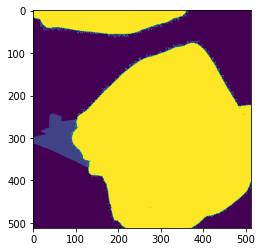

In [283]:
img = cv2.imread(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train2/img/{listdir[0]}')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = cv2.imread(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/mmseg_data/train2/ann/{listdir[0]}')
masks = cv2.cvtColor(masks, cv2.COLOR_BGR2GRAY)

img_dir = '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/add_imgs/clothing'
file_list = os.listdir(img_dir)

print(file_list)
add_img = cv2.imread(img_dir+'/'+file_list[0]+'/clothing101.jpg')
add_img = cv2.cvtColor(add_img, cv2.COLOR_BGR2RGB)
img2gray = cv2.cvtColor(add_img, cv2.COLOR_BGR2GRAY)
_, img2_mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
mask_inv = cv2.bitwise_not(img2_mask)

real_mask = np.where(img2_mask==255, 10, img2_mask) #category 10

new_img = cv2.bitwise_and(img, img, mask=mask_inv) +add_img
new_mask = cv2.bitwise_and(masks, masks, mask=mask_inv) + real_mask

In [572]:
images = []

In [589]:
len(images)

1017

In [588]:
for i in range(len_imgs):
    off_img, aug_mask, ann = distorted_img(i,'clothing.json',1)
    images.append(off_img)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
load

In [590]:
for idx, file in enumerate(images):
    
    plt.imsave(f'/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/add_imgs/clothing/{idx}.jpg', file)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


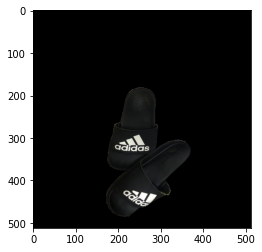

In [79]:
img, mask, ann, image_infos = get_img(1, 'clothing_train.json')
off_img = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(off_img)

In [80]:
count = 0
base_cat_dir = make_dir('glass')
for i in range(len_imgs):
    
    img, mask, ann, image_infos = get_img(i, 'glass_train.json')

    off_img = cv2.bitwise_and(img, img, mask=mask)
    save_img(base_cat_dir, off_img, ann[0], count, 'glass')
    count+=1
    
for i in range(len(images)):
    for _ in range(10):
        off_img, aug_mask, ann = distorted_img(i, 'glass_train.json')
        save_img(base_cat_dir, off_img, ann[0], count, 'glass')
    
        count+=1

FileExistsError: [Errno 17] File exists: '/opt/ml/segmentation/semantic-segmentation-level2-cv-11/input/data/add_imgs/glass'